In [23]:
from imports_and_consts import *

import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split

import xgboost as xgb

from lifelines.utils import concordance_index
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [24]:
data = pd.read_parquet("data/train_val_data.parquet.gzip")

In [25]:
target_cols = ['target', 'target_month', 'target_xgb', 'term']
target_cols

['target', 'target_month', 'target_xgb', 'term']

In [26]:
features = ["annual_inc", "loan_amnt", "fico_average", "emp_length", "acc_open_past_24mths", "avg_cur_bal" , "sub_grade", "int_rate", "revol_util"]
features += [col for col in data.columns if "home_ownership_ohe_" in col]

data_used_cols = data[features + target_cols].dropna()
# assert data.shape[0] == data_used_cols.shape[0]

features

['annual_inc',
 'loan_amnt',
 'fico_average',
 'emp_length',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'sub_grade',
 'int_rate',
 'revol_util',
 'home_ownership_ohe_ANY',
 'home_ownership_ohe_MORTGAGE',
 'home_ownership_ohe_NONE',
 'home_ownership_ohe_OTHER',
 'home_ownership_ohe_OWN',
 'home_ownership_ohe_RENT']

In [27]:
X, y = data_used_cols[features + ['term']], data_used_cols[target_cols]

# Predict

In [28]:
def get_proba_for_month(proba, n_months):
    # PDn = 1 - (1-pd12)^(n/12)

    return 1 - (1 - proba) ** (n_months / 12)
    

In [29]:
def train_xgb_model(X_train, y_train, X_val=None, y_val=None, params={}, verbose_plots=False):
    params['scale_pos_weight'] = (y_train["target_xgb"] == 0).sum() / (y_train["target_xgb"] == 1).sum()

    model = xgb.XGBClassifier(**params)
    if X_val is not None:
        model.fit(
            X_train, y_train["target_xgb"], 
            eval_set=[(X_train, y_train["target_xgb"]), (X_val, y_val["target_xgb"])],
            verbose=False
        )
    else:
        model.fit(
            X_train, y_train["target_xgb"], 
            eval_set=[(X_train, y_train["target_xgb"])],
            verbose=False
        )

    if verbose_plots:
        print(params, features)
        results = model.evals_result()
        epochs = len(results['validation_0']['auc'])
        x_axis = range(0, epochs)
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['auc'], label='Train')
        if X_val is not None:
            ax.plot(x_axis, results['validation_1']['auc'], label='Val')
        ax.legend()
        plt.ylabel('AUC')
        plt.title('XGBoost AUC')
        plt.show()

    # Test model
    if X_val is not None:
        y_val['y_pred'] = model.predict_proba(X_val)[:,1]
        y_val['prob_for_month'] = y_val.apply(lambda x: get_proba_for_month(x.y_pred, x.term), axis=1)

        return model, -y_val['prob_for_month']
    else:
        return model

In [30]:
def objective(trial):

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': 5000,
        'subsample': trial.suggest_float('subsample', 0.25, 0.7, log=True),
        'min_child_weight': 30,
        'early_stopping_rounds': 10,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10, log=True),
        'seed': SEED,
    }

    # Train and test model on each fold
    metrics = []
    for train_index, val_index in list(skf.split(X, y["target_xgb"]))[:3]:
        X_train, X_val = X_train_val.iloc[train_index].copy(), X_train_val.iloc[val_index].copy()
        y_train, y_val = y_train_val.iloc[train_index].copy(), y_train_val.iloc[val_index].copy()
        
        model, prob_for_month = train_xgb_model(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, params=params, verbose_plots=True)

        c_ind = concordance_index(
            event_times=y_val["target_month"], predicted_scores=prob_for_month, event_observed=y_val['target']
        )

        metrics.append(c_ind)
        print(
            "C_INDEX", round(
                c_ind, 5
            )
        )

    return np.mean(metrics)

In [31]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=3)

{'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 100, 'subsample': 0.6647914335903077, 'min_child_weight': 30, 'early_stopping_rounds': 10, 'learning_rate': 0.025066311555882063, 'max_depth': 9, 'seed': 69, 'scale_pos_weight': 12.71626582824497} ['annual_inc', 'loan_amnt', 'fico_average', 'emp_length', 'acc_open_past_24mths', 'avg_cur_bal', 'sub_grade', 'int_rate', 'revol_util', 'home_ownership_ohe_ANY', 'home_ownership_ohe_MORTGAGE', 'home_ownership_ohe_NONE', 'home_ownership_ohe_OTHER', 'home_ownership_ohe_OWN', 'home_ownership_ohe_RENT']


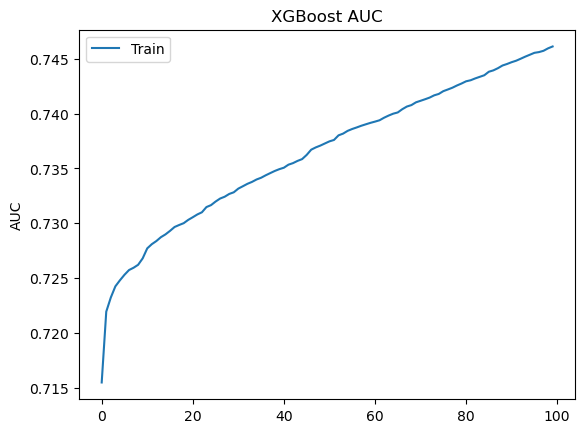

In [32]:
best_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': 100,
        'subsample': 0.6647914335903077,
        'min_child_weight': 30,
        'early_stopping_rounds': 10,
        'learning_rate': 0.025066311555882063,
        'max_depth': 9,
        'seed': SEED,
    }

model = train_xgb_model(X_train=X, y_train=y, X_val=None, y_val=None, params=best_params, verbose_plots=True)

In [33]:
import pickle
file_name = "xgb_model.pickle"

pickle.dump(model, open(file_name, "wb"))